In [1]:
import math
import torch
import qpytorch
import matplotlib.pyplot as plt
%matplotlib inline

# Different objective functions for Approximate QEPs


(*N.B.* this tutorial assumes that you are familiar with **inducing point methods**.
For an introduction to these methods, please see [Quinonero-Candela and Rasmussen, 2005](http://www.jmlr.org/papers/volume6/quinonero-candela05a/quinonero-candela05a.pdf).)

## Overview

Approximate Q-Exponential processes learn an approximate posterior distribution

$$ p(\mathbf f(X) \mid y) \approx q(\mathbf f) = \int( p(\mathbf f \mid \mathbf u) \: q(\mathbf u) d \mathbf u$$

where $\mathbf u$ are the function values at some **inducing points** $\mathbf u$.
Typically, $q(\mathbf u)$ is chosen to be a multivariate q-exponential -- i.e. $q(\mathbf u) = \mathcal Q (\mathbf m, \mathbf S)$.

We choose the approximate posterior $\int( p(\mathbf f \mid \mathbf u) \: q(\mathbf u) d \mathbf u$ by optimizing the parameters of $q(\mathbf u)$ (i.e. $\mathbf m$ and $\mathbf S$. There are several objectives that we can use for optimization. We'll test out the following two:

1. The Variational ELBO (see [Hensman et al., 2015](http://proceedings.mlr.press/v38/hensman15.pdf))
2. The Predictive Log Likelihood (see [Jankowiak et al., 2020](http://arxiv.org/)).

### Experimental setup

We're going to train an approximate QEP on a 1D regression dataset with heteroskedastic noise.

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

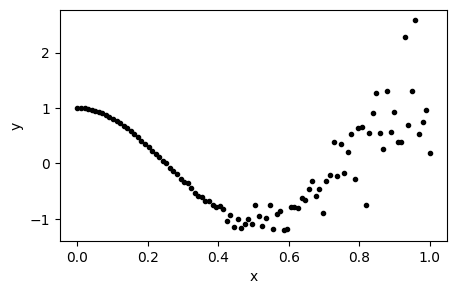

In [2]:
# Define some training data
train_x = torch.linspace(0, 1, 100)
train_y = torch.cos(train_x * 2 * math.pi) + torch.randn(100).mul(train_x.pow(3) * 1.)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.scatter(train_x, train_y, c='k', marker='.', label="Data")
ax.set(xlabel="x", ylabel="y")

Here's a simple approximate QEP model, and a script to optimize/test the model with different objective functions:

In [3]:
POWER = 1.0
class ApproximateQEPModel(qpytorch.models.ApproximateQEP):
    def __init__(self, inducing_points):
        self.power = torch.tensor(POWER)
        variational_distribution = qpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-1), power=self.power)
        variational_strategy = qpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = qpytorch.means.ConstantMean()
        self.covar_module = qpytorch.kernels.ScaleKernel(qpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)

In [18]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 200


# Our testing script takes in a QPyTorch MLL (objective function) class
# and then trains/tests an approximate QEP with it on the supplied dataset

def train_and_test_approximate_qep(objective_function_cls):
    model = ApproximateQEPModel(torch.linspace(0, 1, 100))
    likelihood = qpytorch.likelihoods.QExponentialLikelihood(power=model.power)
    objective_function = objective_function_cls(likelihood, model, num_data=train_y.numel())
    optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

    # Train
    model.train()
    likelihood.train()
    for _ in range(training_iterations):
        output = model(train_x)
        loss = -objective_function(output, train_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Test
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        f_dist = model(train_x)
        mean = f_dist.mean
        f_lower, f_upper = f_dist.confidence_region()
        y_dist = likelihood(f_dist)
        y_lower, y_upper = y_dist.confidence_region()

    # Plot model
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    line, = ax.plot(train_x, mean, "blue")
    ax.fill_between(train_x, f_lower, f_upper, color=line.get_color(), alpha=0.3, label="q(f)")
    ax.fill_between(train_x, y_lower, y_upper, color=line.get_color(), alpha=0.1, label="p(y)")
    ax.scatter(train_x, train_y, c='k', marker='.', label="Data")
    ax.legend(loc="best")
    ax.set(xlabel="x", ylabel="y")

## Objective Funtion 1) The Variational ELBO

The **variational evidence lower bound** - or ELBO - is the most common objective function. It can be derived as an lower bound on the likelihood $p(\mathbf y \! \mid \! \mathbf X)$:

$$  \mathcal{L}_\text{ELBO} =  \sum_{i=1}^N \mathbb{E}_{q( \mathbf u)} \left[ \mathbb{E}_{f( \mathbf f \mid \mathbf u)} \left[    \log p( y_i \! \mid \! f_i)  \right] \right] - \beta \: \text{KL} \left[ q( \mathbf u) \Vert p( \mathbf u) \right]$$

where $N$ is the number of datapoints and $p(\mathbf u)$ is the prior distribution for the inducing function
values. For more information on this derivation, see [Hensman et al., 2015](http://proceedings.mlr.press/v38/hensman15.pdf).

### How to use the variational ELBO in QPyTorch

In QPyTorch, this objective function is available as [qpytorch.mlls.VariationalELBO](https://qepytorch.readthedocs.io/en/stable/marginal_log_likelihoods.html#variationalelbo).

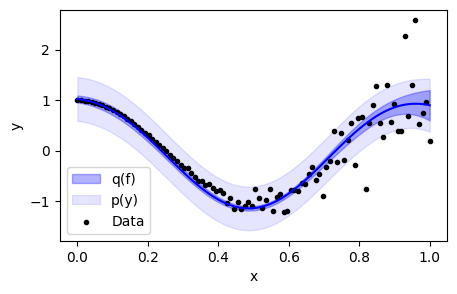

In [19]:
train_and_test_approximate_qep(qpytorch.mlls.VariationalELBO)

## Objective Funtion 2) The Predictive Log Likelihood

The **predictive log likelihood** is an alternative to the variational ELBO that was proposed in [Jankowiak et al., 2020](https://arxiv.org/abs/1910.07123).
It typically produces predictive variances than the `qpytorch.mlls.VariationalELBO` objective.

$$
\begin{align}
\mathcal{L}_\text{PLL} &= \mathbb{E}_{p_\text{data}( y, \mathbf x )} \left[ \log p( y \! \mid \! \mathbf x)  \right] - \beta \: \text{KL} \left[ q( \mathbf u) \Vert p( \mathbf u) \right] \\ 
  &\approx \sum_{i=1}^N \log \mathbb{E}_{q(\mathbf u)} \left[ \int p( y_i \! \mid \! f_i) p(f_i \! \mid \! \mathbf u) \: d f_i \right] - \beta \: \text{KL} \left[ q( \mathbf u) \Vert p( \mathbf u) \right] 
\end{align}
$$

Note that this objective is *very similar* to the variational ELBO.
The only difference is that the $\log$ occurs *outside* the expectation $\mathbb E_{q(\mathbf u)}$.
This difference results in very different predictive performance.

### How to use the predictive log likelihood in QPyTorch

In QPyTorch, this objective function is available as [qpytorch.mlls.PredictiveLogLikelihood](https://qepytorch.readthedocs.io/en/stable/marginal_log_likelihoods.html#predictiveloglikelihood).

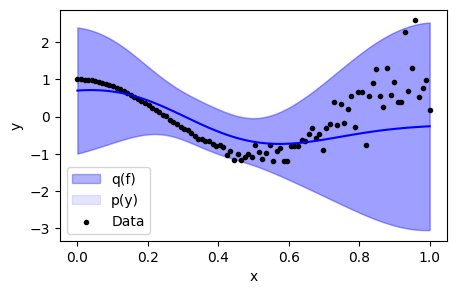

In [25]:
train_and_test_approximate_qep(qpytorch.mlls.PredictiveLogLikelihood)